In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
from tqdm import tqdm

import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread

%load_ext autoreload
%autoreload 2
# repo_path = r'E:\TMC\PRISM_Code'
# package_path = repo_path / '' 
# if package_path not in sys.path: sys.path.append(package_path)

BASE_DIR = Path(r'F:\spatial_data\processed')
RUN_ID = '20230523_HCC_PRISM_probe_refined'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'

In [4]:
#read cell centroid
centroids = pd.read_csv(seg_dir/'centroids_all.csv', header=None).to_numpy()
print('centroids_num:',len(centroids))

#read all labeled rna
rna_df = pd.read_csv(seg_dir/'rna_labeled.csv')
rna_df

centroids_num: 88851


,Y,X,Gene,Cell Index
0,22843,25425,PRISM_26,56196
1,16238,28140,PRISM_26,29753
2,7673,22365,PRISM_26,6249
3,8492,23897,PRISM_26,7833
4,23116,3558,PRISM_26,57113
...,...,...,...,...
1980153,25546,28856,PRISM_16,66395
1980154,18319,1678,PRISM_16,37043
1980155,25474,24608,PRISM_16,66229
1980156,6774,17877,PRISM_16,4600


In [8]:
# read mask ROI
Mask = imread(visual_dir/'Mask.tif')
Mask.shape

(31255, 15837)

In [8]:
# reserve nucleus that is in ROI
cell_df = pd.DataFrame(centroids)
cell_df['AP'] = Mask[centroids[:,0],centroids[:,1]]

In [9]:
# reserve Cell Index that is in ROI
NTS_rna_labeled = rna_df[rna_df['Cell Index'].isin(list(cell_df[cell_df['AP']!=0].index))]

In [11]:
# Generate Expression matrix that is in ROI
match_df = NTS_rna_labeled.copy()
match_df['Count'] = np.ones(len(match_df))
match_df_group = match_df[['Cell Index','Gene','Count']].groupby(['Cell Index','Gene']).count()
matrix = match_df_group.unstack().fillna(0)
matrix.columns = matrix.columns.droplevel()
matrix.columns.name = None
matrix.index.name = None
matrix = matrix.drop(columns='Other')
matrix['sum'] = matrix.iloc[:,0:57].sum(axis=1)
# filter matrix by count
matrix = matrix[matrix['sum']>=5]
matrix = matrix.drop(columns='sum')
matrix

,ACSL6,ALDH1L1,ANK2,AQP4,ATP1B2,ATXN2,BCAN,BTBD17,CD24A,CDH22,...,NRXN3,PHKG1,PLPP3,PPP1R17,S100B,SLC1A3,SLC6A11,SLC7A10,STX8,TRIL
1,2.0,0.0,1.0,3.0,5.0,2.0,0.0,3.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,7.0,26.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,...,1.0,0.0,0.0,0.0,1.0,3.0,21.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,10.0,3.0,1.0,3.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,12.0,32.0,0.0,0.0,0.0
5,2.0,2.0,0.0,0.0,7.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,2.0,6.0,11.0,0.0,0.0,0.0
6,3.0,0.0,1.0,6.0,12.0,0.0,1.0,1.0,6.0,2.0,...,3.0,0.0,1.0,0.0,2.0,11.0,46.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133659,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
133660,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
133661,0.0,1.0,1.0,0.0,5.0,1.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0
133663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


/tmp/ipykernel_305665/3493029220.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_corr.values[[np.arange(df_corr.shape[0])]*2] = None


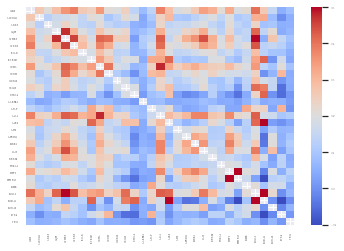

In [16]:
# Draw co=expression matrix
import matplotlib.pyplot as plt
from draw_spots import crop_df
from skimage.io import imread
from skimage.io import imsave
import numpy as np
from glob import glob
import os
from tqdm import tqdm
from tqdm import trange
import seaborn as sns
df_pre_corr = matrix
df_pre_corr = df_pre_corr / df_pre_corr.sum()
df_corr = df_pre_corr.corr()
df_corr.values[[np.arange(df_corr.shape[0])]*2] = None
#df_corr = df_corr.sort_values(by='Gfap',ascending=False)
df_corr.to_csv(visual_dir/'df_coor.csv')
sns.set(font_scale=0.2)
ax = sns.heatmap(df_corr,cmap='coolwarm',xticklabels=1,yticklabels=1,vmin=-0.1,vmax=0.5)
plt.savefig(visual_dir/'cell-co-expression.pdf')
plt.show()

In [14]:
matrix.to_csv(visual_dir/'NTS_expression_matrix.csv')